# Implementacion de MIMO en SVR

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate

from sklearn.svm import SVR
#from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 

from datetime import datetime, timedelta

In [2]:
df_Nizanda = pd.read_csv('./Datasets/Nizanda_T1.csv')
df_Nizanda

,Day,Month,Year,Hour,Barometer,Temp C,High Temp C,Low Temp C,Hum %,Dew Point C,...,Wind Run,High Wind Speed m/s,High Wind Direction,Wind Chill C,Heat Index C,THW Index C,Rain mm,Rain Rate mm/h,ET mm,Date
0,1,1,2017,0,754.7,25.2,25.7,24.9,84.0,22.3,...,3.1,11.2,NW,25.2,27.3,27.3,0.0,0.0,NaN,2017-01-01 00:00:00
1,1,1,2017,1,754.5,24.6,24.9,24.4,86.0,22.1,...,3.1,11.2,WNW,24.6,26.5,26.5,0.0,0.0,NaN,2017-01-01 01:00:00
2,1,1,2017,2,754.2,24.5,24.6,24.4,81.0,21.0,...,2.7,10.7,WNW,24.5,26.2,26.2,0.0,0.0,NaN,2017-01-01 02:00:00
3,1,1,2017,3,753.9,24.4,24.6,24.2,84.0,21.5,...,3.1,10.7,WNW,24.4,26.1,26.1,0.0,0.0,NaN,2017-01-01 03:00:00
4,1,1,2017,4,753.7,24.1,24.3,24.1,86.0,21.6,...,3.1,12.5,WNW,24.1,25.9,25.9,0.0,0.0,NaN,2017-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17406,31,12,2018,19,754.6,26.6,26.8,26.4,73.0,21.4,...,2.2,9.4,N,26.6,28.4,28.4,0.0,0.0,NaN,2018-12-31 19:00:00
17407,31,12,2018,20,754.8,26.2,26.4,26.0,75.0,21.4,...,2.2,9.8,WNW,26.2,27.9,27.9,0.0,0.0,NaN,2018-12-31 20:00:00
17408,31,12,2018,21,755.0,25.9,26.0,25.8,74.0,20.9,...,2.2,8.5,N,25.9,27.4,27.4,0.0,0.0,NaN,2018-12-31 21:00:00
17409,31,12,2018,22,755.4,25.7,25.8,25.5,75.0,20.9,...,1.8,7.1,NE,25.7,27.2,27.2,0.0,0.0,NaN,2018-12-31 22:00:00


In [3]:
def data_preprocessing(df, scaler):        
    # Escalando el dataset
    data_scaled = scaler.transform(df)

    values = data_scaled
    
    if len(df.columns) == 1:
        values = values[:, 0]
    
    return values, len(df.columns)

In [4]:
def get_labeled_window(data, window_size, horizon, n_cols):
    if n_cols == 1:
        return data[:, :window_size], data[:, -horizon:]
    else:
        #print(data.shape)
        return data[:, :window_size], data[:, -horizon:, 3]
    
def make_windows(data, input_size, horizon, n_cols, shift = 0):
    # Crea una matriz 2D con el la longuitud del input size + horizon
    window_step = np.expand_dims(np.arange(input_size + horizon + shift), axis = 0)
    window_indexes = window_step + np.expand_dims(np.arange(len(data) - (shift + input_size + horizon - 1)), axis = 0).T
    windowed_array = data[window_indexes]
    
    windows, labels = get_labeled_window(windowed_array, window_size = input_size, horizon = horizon, n_cols = n_cols)
    
    return windows, labels

In [5]:
def run_experiment(data, window, horizon, shift, scaler, cv, model):
    w, n_cols = data_preprocessing(data, scaler)
    x_, y_ = make_windows(w, input_size = window, horizon = horizon, shift = shift, n_cols = n_cols)

    if len(x_.shape) > 2:
        # Convertir a arreglo de 2 dimensiones
        rows, nx, ny = x_.shape
        x_ = x_.reshape((rows, nx*ny))
        
    cv_results = cross_validate(
        model,
        x_,
        y_,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error", "r2"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    r2 = cv_results["test_r2"]
    print(
        f"Coefficient of determination: {r2.mean():.3f} +/- {r2.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}\n"
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
    )
    return {'r2': r2.mean(), 'rmse': rmse.mean(), 'mae': mae.mean()}

In [6]:
def run_test(data, window, horizon, shift, scaler, model):
    w, n_cols = data_preprocessing(data, scaler)
    x_, y_ = make_windows(w, input_size= window, horizon = horizon, shift = shift,  n_cols = n_cols)
    
    if len(x_.shape) > 2:
        # Convertir a arreglo de 2 dimensiones
        rows, nx, ny = x_.shape
        x_ = x_.reshape((rows, nx*ny))
    
    ### CAMBIAR LA FORMA DE LAS PRUEBAS
    ### AL HACER LA PRUEBA NO ES NECESARIO HACER EL FIT, DEBIDO A QUE SE TIENE QUE USAR EL MODELO DE ENTRENAMIENTO
    #model.fit(x_, y_)
    y_pred = model.predict(x_)
    
    r2 = r2_score(y_, y_pred)
    mae = mean_absolute_error(y_, y_pred)
    rmse = mean_squared_error(y_, y_pred, squared= False)
    return {'r2': r2, 'rmse': rmse, 'mae': mae}, y_pred

In [7]:
# Graficando la regresion lineal dentro de la serie de tiempo del viento
def plot_series(Y_true, Y_pred, title = 'Serie de Tiempo de la velocidad del viento', vline = False):
    gris_uat = '#CFCDC9' #(207, 205, 201)
    azul_uat = '#4070B6' #(0, 66, 106)
    naranja_uat = '#ECB06F' #(184, 97, 106)
    #gris_uat_a = '#CFCDC9' #(207, 205, 201)
    
    
    fig, ax = plt.subplots(figsize = (16,8))
    ax.plot(Y_true, color = gris_uat, label = 'Reales')
    ax.plot(Y_pred, color = azul_uat, label = 'Predicciones')
    
    if(vline == True):
        # only one line may be specified; full height
        plt.axvline(x = len(Y_true) - 25, color = naranja_uat, ls = '--')
    
    ax.set_title(title);
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.ylabel('Velocidad del viento m/s')
    plt.xlabel('Horas')
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    
    #plt.legend(loc='upper right')

In [8]:
def previous_date(current_date, frmt='%Y-%m-%d-%H', days = 1, string=True):
    yesterday = current_date - timedelta(days)
    if string:
        return yesterday.strftime(frmt), current_date.strftime(frmt)
    return yesterday

In [9]:
def scale_column(df,column):
    column_max = df[column].max()
    column_min = df[column].min()
    for i in range(df[column].count()):
        df.loc[i,column] = (df.loc[i,column] - column_min) / (column_max - column_min)

In [10]:
# Lista de combinaciones para los experimentos
list1 = [['Month', 'Day', 'Hour', 'High Wind Speed m/s'], ['High Wind Speed m/s']]
list2 = [24, 48, 72, 96]
list3 = [1, 24]
listcomb = [list1, list2, list3]
# Realiza las distitnas combinaciones
combinations = [p for p in itertools.product(*listcomb)]
# Elimina las combinaciones SIMO
for idx, comb in enumerate(combinations):
    if comb[2] == 24 and comb[0] == 'High Wind Speed m/s':
        combinations.pop(idx)

# Agrega cada combinacion a su respectiva lista
list_rect = []
list_mimo = []
for comb in combinations:
    if comb[2] == 1:
        list_rect.append(comb)
    else:
        list_mimo.append(comb)

In [12]:
# Realizacion de todas las combinaciones de los experminetos de entrenamiento (CHECAR BIEN EL CODIGO)
tscv = TimeSeriesSplit(n_splits = 5)
model = LinearRegression()
minmax_scl = MinMaxScaler()
    
for i, comb in enumerate(list_rect):
    
    df_train = df_Nizanda.copy()
    drop_cols = [col for col in df_Nizanda.columns if col not in comb[0]]
    df_train.drop(drop_cols, axis = 1, inplace = True)
    #print(df_train.columns)
    
    minmax_scl.fit(df_train)
    
    print('---Run Experiment: ', str(i + 1) + '---')
    train_dict = run_experiment(df_train, window = comb[1], horizon = comb[2], shift = 0, scaler = minmax_scl, cv = tscv, model = model)
    
    df_LR_train.loc[len(df_LR_train.index)] = ['LR', comb[2], train_dict['r2'], train_dict['rmse'], train_dict['mae'], [comb[0], comb[1], comb[2]]]
print('Runs experiment finished')

NameError: name 'LinearRegression' is not defined

In [134]:
import numpy as np
from numpy import concatenate

# from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
# import statistics

def create_dataset(ts, dim ,h):
    look_back = dim + h - 1
    print(look_back)
    # dataset = np.insert(dataset, [0] * look_back, 0)
    dataX, dataY = [], []
    for i in range(len(ts) - look_back):
        a = ts[i:(i + look_back)]
        dataX.append(a)
        dataY.append(ts[i + look_back])
    print(dataX[0])
    print('-------------------')
    print(dataY[0])
    dataY = np.array(dataY)
    dataY = np.reshape(dataY, (dataY.shape[0], 1))
    print('************')
    print(dataY)
    print(len(dataY))
    dataset = np.concatenate((dataX, dataY), axis=1)
    return dataset


def unpadding(y):
    a = y.copy()
    h = y.shape[1]
    s = np.empty(y.shape[0] + y.shape[1] -1)

    for i in range(s.shape[0]):
        s[i]=np.diagonal(np.flip(a,1), offset= -i + h-1,axis1=0,axis2=1).copy().mean()
    
    return s

def mape(y_true, y_pred): 
    y_true = unpadding(y_true)
    y_pred = unpadding(y_pred)

    mask =  y_true != 0.0
    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)
    N_metric =  (y_true[mask] - y_pred[mask])/y_true[mask]
    N_metric = np.fabs(N_metric)
    metric = N_metric.mean()

    return metric

def smape(y_true, y_pred): 
    y_true = unpadding(y_true)
    y_pred = unpadding(y_pred)

    mask =  y_true != 0.0
    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)
    N_metric =  (y_true[mask] - y_pred[mask])/(y_true[mask] + y_pred[mask])
    N_metric = np.fabs(N_metric)
    metric = N_metric.mean()

def rmse(y_true, y_pred):
    y_true = unpadding(y_true)
    y_pred = unpadding(y_pred)

    return mean_squared_error(y_true,y_pred, squared = False) #np.sqrt(mean_squared_error(y_true,y_pred))

def r2(y_true, y_pred):
    y_true = unpadding(y_true)
    y_pred = unpadding(y_pred)
    
    return r2_score(y_true, y_pred)

def mae(y_true, y_pred):
    y_true = unpadding(y_true)
    y_pred = unpadding(y_pred)
    
    return mean_absolute_error(y_true, y_pred)

In [12]:
import numpy as np
from sklearn.metrics.pairwise import pairwise_kernels

class MSVR():
    def __init__(self, kernel='rbf', degree=3, gamma=None, coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, params = None):
        super(MSVR, self).__init__()
        self.kernel = kernel
        self.degree = degree
        self.gamma = gamma
        self.coef0 = coef0
        self.tol = tol
        self.C = C
        self.epsilon = epsilon
        self.Beta = None
        self.NSV = None
        self.xTrain = None
        
        if params != None:
            self.C = params['C'][0]
            self.epsilon = params['epsilon'][0]
            self.gamma = params['gamma'][0]
            self.kernel = params['kernel'][0]
        #print(str(self.C))

    def fit(self, x, y):
        self.xTrain = x.copy()
        C = self.C
        epsi = self.epsilon
        tol = self.tol

        n_m = np.shape(x)[0]  # num of samples
        n_d = np.shape(x)[1]  # input data dimensionality
        n_k = np.shape(y)[1]  # output data dimensionality (output variables)

        # H = kernelmatrix(ker, x, x, par)
        H = pairwise_kernels(x, x, metric=self.kernel, filter_params=True,
                             degree=self.degree, gamma=self.gamma, coef0=self.coef0)

        self.Beta = np.zeros((n_m, n_k))

        #E = prediction error per output (n_m * n_k)
        E = y - np.dot(H, self.Beta)
        #RSE
        u = np.sqrt(np.sum(E**2, 1, keepdims=True))

        #RMSE
        RMSE = []
        RMSE_0 = np.sqrt(np.mean(u**2))
        RMSE.append(RMSE_0)

        #points for which prediction error is larger than epsilon
        i1 = np.where(u > epsi)[0]

        #set initial values of alphas a (n_m * 1)
        a = 2 * C * (u - epsi) / u

        #L (n_m * 1)
        L = np.zeros(u.shape)

        # we modify only entries for which  u > epsi. with the sq slack
        L[i1] = u[i1]**2 - 2 * epsi * u[i1] + epsi**2

        #Lp is the quantity to minimize (sq norm of parameters + slacks)
        Lp = []
        BetaH = np.dot(np.dot(self.Beta.T, H), self.Beta)
        Lp_0 = np.sum(np.diag(BetaH), 0) / 2 + C * np.sum(L)/2
        Lp.append(Lp_0)

        eta = 1
        k = 1
        hacer = 1
        val = 1

        while(hacer):
            Beta_a = self.Beta.copy()
            E_a = E.copy()
            u_a = u.copy()
            i1_a = i1.copy()

            M1 = H[i1][:, i1] + \
                np.diagflat(1/a[i1]) + 1e-10 * np.eye(len(a[i1]))

            #compute betas
            #       sal1 = np.dot(np.linalg.pinv(M1),y[i1])  #求逆or广义逆（M-P逆）无法保证M1一定是可逆的？
            sal1 = np.dot(np.linalg.inv(M1), y[i1])

            eta = 1
            self.Beta = np.zeros(self.Beta.shape)
            self.Beta[i1] = sal1.copy()

            #error
            E = y - np.dot(H, self.Beta)
            #RSE
            u = np.sqrt(np.sum(E**2, 1)).reshape(n_m, 1)
            i1 = np.where(u >= epsi)[0]

            L = np.zeros(u.shape)
            L[i1] = u[i1]**2 - 2 * epsi * u[i1] + epsi**2

            #%recompute the loss function
            BetaH = np.dot(np.dot(self.Beta.T, H), self.Beta)
            Lp_k = np.sum(np.diag(BetaH), 0) / 2 + C * np.sum(L)/2
            Lp.append(Lp_k)

            #Loop where we keep alphas and modify betas
            while(Lp[k] > Lp[k-1]):
                eta = eta/10
                i1 = i1_a.copy()

                self.Beta = np.zeros(self.Beta.shape)
                #%the new betas are a combination of the current (sal1)
                #and of the previous iteration (Beta_a)
                self.Beta[i1] = eta*sal1 + (1-eta)*Beta_a[i1]

                E = y - np.dot(H, self.Beta)
                u = np.sqrt(np.sum(E**2, 1)).reshape(n_m, 1)

                i1 = np.where(u >= epsi)[0]

                L = np.zeros(u.shape)
                L[i1] = u[i1]**2 - 2 * epsi * u[i1] + epsi**2
                BetaH = np.dot(np.dot(self.Beta.T, H), self.Beta)
                Lp_k = np.sum(np.diag(BetaH), 0) / 2 + C * np.sum(L)/2
                Lp[k] = Lp_k

                #stopping criterion 1
                if(eta < 1e-16):
                    Lp[k] = Lp[k-1] - 1e-15
                    self.Beta = Beta_a.copy()

                    u = u_a.copy()
                    i1 = i1_a.copy()

                    hacer = 0

            #here we modify the alphas and keep betas
            a_a = a.copy()
            a = 2 * C * (u - epsi) / u

            RMSE_k = np.sqrt(np.mean(u**2))
            RMSE.append(RMSE_k)

            if((Lp[k-1]-Lp[k])/Lp[k-1] < tol):
                hacer = 0

            k = k + 1

            #stopping criterion #algorithm does not converge. (val = -1)
            if(len(i1) == 0):
                hacer = 0
                self.Beta = np.zeros(self.Beta.shape)
                val = -1

        self.NSV = len(i1)

    def predict(self, x):
        H = pairwise_kernels(x, self.xTrain, metric=self.kernel, filter_params=True,
                             degree=self.degree, gamma=self.gamma, coef0=self.coef0)
        yPred = np.dot(H, self.Beta)
        return yPred

    # def score(self,x):

In [13]:
comb = list_mimo[0]
comb

(['Month', 'Day', 'Hour', 'High Wind Speed m/s'], 24, 24)

In [14]:
#model = SVR()
minmax_scl = MinMaxScaler()

df_train = df_Nizanda.copy()
drop_cols = [col for col in df_Nizanda.columns if col not in comb[0]]
df_train.drop(drop_cols, axis = 1, inplace = True)
minmax_scl.fit(df_train)

window = comb[1]
horizon = comb[2]
shift = 0
w, n_cols = data_preprocessing(df_train, minmax_scl)
x_, y_ = make_windows(w, input_size = window, horizon = horizon, shift = shift, n_cols = n_cols)
    
if len(x_.shape) > 2:
        # Convertir a arreglo de 2 dimensiones
        rows, nx, ny = x_.shape
        x_ = x_.reshape((rows, nx*ny))

In [16]:
y_

array([[0.55251142, 0.47031963, 0.51141553, ..., 0.32420091, 0.38812785,
        0.47031963],
       [0.47031963, 0.51141553, 0.47031963, ..., 0.38812785, 0.47031963,
        0.42922374],
       [0.51141553, 0.47031963, 0.32420091, ..., 0.47031963, 0.42922374,
        0.42922374],
       ...,
       [0.34703196, 0.38812785, 0.38812785, ..., 0.42922374, 0.44748858,
        0.38812785],
       [0.38812785, 0.38812785, 0.40639269, ..., 0.44748858, 0.38812785,
        0.32420091],
       [0.38812785, 0.40639269, 0.40639269, ..., 0.38812785, 0.32420091,
        0.42922374]])

In [17]:
tscv = TimeSeriesSplit(n_splits = 4)

In [18]:
parameters = {'C': [1, 10, 100, 1000], 'epsilon': [0.001, 0.01, 0.1, 1], 'gamma': [0.001, 0.01, 0.1, 1],'kernel': ['rbf']}
keys = ['epsilon', 'C', 'gamma']
p = {'C': [1, 10], 'epsilon': [0.001, 0.01], 'gamma': [0.001, 0.01],'kernel': ['rbf']}
#kernel = 'rbf', gamma = 0.1, epsilon=0.001

In [19]:
def CV(x_, y_, tscv, params, key):
    best_param = ""
    best_score = -9999
    testmetric = []
    #print(key)
    #print(params[])
    for param in params[key]:
        #print(param)
        mean_r2 = 0.0
        params.update({key: [param]})
        for k, (train_index, test_index) in enumerate(tscv.split(x_)):
            print(f"Fold {k}:")
            #print(f"  Train: index={train_index}")
            #print(f"  Test:  index={test_index}")
            #print(params)
            msvr = MSVR(params = params)
            msvr.fit(x_[train_index], y_[train_index])

            #trainPred = msvr.predict(x_[train_index])
            #trainr2 = r2(y_[train_index], trainPred)
            #trainmetric.append(trainr2)

            testPred = msvr.predict(x_[test_index])
            testr2 = r2(y_[test_index], testPred)
            testmetric.append(testr2)

        sum_r2 = sum(testmetric)
        mean_r2 = sum_r2 / len(testmetric)
        #mean_r2 += 1
        if best_score < mean_r2:
            best_score = mean_r2
            best_param = str(param)
    print(best_param + " : " + str(best_score))
    return best_param

In [31]:
bestparams = {'C': [1], 'epsilon': [0.1], 'gamma': [0.1],'kernel': ['rbf']}
for j in range(3):
    print('--Etapa ' + str(j + 1) + '--')
    print('GS: '+ str(keys[j]))
    bestparams.update({keys[j]: p[keys[j]]})
    print(bestparams)
    best_param = CV(x_, y_, tscv, bestparams, keys[j])
    #print(best_param)
    bestparams.update({keys[j]: [best_param]})
    print('Parametro acutalizado: ' + str(bestparams))

--Etapa 1--
GS: epsilon
{'C': [1], 'epsilon': [0.001, 0.01], 'gamma': [0.1], 'kernel': ['rbf']}
Fold 0:
Fold 1:
Fold 2:
Fold 3:


KeyboardInterrupt: 

In [56]:
best_param = 0
# Seleccion de parametros
trainmetric = []
testmetric = []

# CROSS VALIDATION
for i, (train_index, test_index) in enumerate(tscv.split(x_)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")
    msvr = MSVR(kernel = 'rbf', gamma = 0.1, epsilon=0.001)
    msvr.fit(x_[train_index], y_[train_index])
    
    trainPred = msvr.predict(x_[train_index])
    trainr2 = r2(y_[train_index], trainPred)
    trainmetric.append(trainr2)
    
    testPred = msvr.predict(x_[test_index])
    testr2 = r2(y_[test_index], testPred)
    testmetric.append(testr2)

    
print('Entrenamiento')
print(trainmetric)
print('Validacion')
print(testmetric)

Fold 0:
  Train: index=[   0    1    2 ... 3473 3474 3475]
  Test:  index=[3476 3477 3478 ... 6945 6946 6947]
Fold 1:
  Train: index=[   0    1    2 ... 6945 6946 6947]
  Test:  index=[ 6948  6949  6950 ... 10417 10418 10419]
Fold 2:
  Train: index=[    0     1     2 ... 10417 10418 10419]
  Test:  index=[10420 10421 10422 ... 13889 13890 13891]
Fold 3:
  Train: index=[    0     1     2 ... 13889 13890 13891]
  Test:  index=[13892 13893 13894 ... 17361 17362 17363]
Entrenamiento
[0.7273803128889078, 0.7394002822840687, 0.7420071314681821, 0.7277646514948299]
Validacion
[0.07646918951109816, 0.2817746379015329, 0.6184437888647301, 0.5836759866247567]


In [57]:
sum_r2 = sum(trainmetric)
mean_r2 = sum_r2 / len(trainmetric)
mean_r2

0.7341380945339973

In [44]:
sum_r2 = sum(testmetric)
mean_r2 = sum_r2 / len(testmetric)
mean_r2

0.39009090072552943

In [54]:
msvr = MSVR(kernel = 'rbf', gamma = 0.1, epsilon=0.001)
msvr.fit(x_, y_)
    
testPred = msvr.predict(x_)
testr2 = r2(y_, testPred)

In [55]:
testr2

0.7206798606974116

In [46]:
x_[0]

array([0.        , 0.        , 0.        , 0.51141553, 0.        ,
       0.        , 0.04347826, 0.51141553, 0.        , 0.        ,
       0.08695652, 0.48858447, 0.        , 0.        , 0.13043478,
       0.48858447, 0.        , 0.        , 0.17391304, 0.57077626,
       0.        , 0.        , 0.2173913 , 0.51141553, 0.        ,
       0.        , 0.26086957, 0.55251142, 0.        , 0.        ,
       0.30434783, 0.57077626, 0.        , 0.        , 0.34782609,
       0.61187215, 0.        , 0.        , 0.39130435, 0.57077626,
       0.        , 0.        , 0.43478261, 0.55251142, 0.        ,
       0.        , 0.47826087, 0.67579909, 0.        , 0.        ,
       0.52173913, 0.55251142, 0.        , 0.        , 0.56521739,
       0.59360731, 0.        , 0.        , 0.60869565, 0.52968037,
       0.        , 0.        , 0.65217391, 0.57077626, 0.        ,
       0.        , 0.69565217, 0.65296804, 0.        , 0.        ,
       0.73913043, 0.47031963, 0.        , 0.        , 0.78260

In [47]:
y_[0]

array([0.55251142, 0.47031963, 0.51141553, 0.47031963, 0.32420091,
       0.40639269, 0.44748858, 0.42922374, 0.42922374, 0.52968037,
       0.48858447, 0.57077626, 0.55251142, 0.52968037, 0.48858447,
       0.48858447, 0.52968037, 0.52968037, 0.48858447, 0.48858447,
       0.44748858, 0.32420091, 0.38812785, 0.47031963])

In [122]:
minmax_scl.fit(df_train)
q = df_train['High Wind Speed m/s'].values

### Ejemplo de uso

In [178]:
# y: num_smaples * outputH
#ts = np.sin(np.arange(0, 9, 0.01)).reshape(-1)
segmentation = int(len(df_train)*2/3)
print(segmentation)
dim = 24
h = 24

dataset = create_dataset(df_train['High Wind Speed m/s'].values, dim, h)
X, Y = dataset[:, :(0 - h)], dataset[:, (0-h):]
train_input = X[:segmentation, :]
train_target = Y[:segmentation].reshape(-1, h)
test_input = X[segmentation:, :]
test_target = Y[segmentation:].reshape(-1, h)

msvr = MSVR(kernel = 'rbf', gamma = 0.1, epsilon=0.001)
# Train
msvr.fit(train_input, train_target)

# Predict with train set
trainPred = msvr.predict(train_input)
# Predict with test set
testPred = msvr.predict(test_input)

trainMetric = rmse(train_target,trainPred)
testMetric = rmse(test_target, testPred)



print(trainMetric, testMetric)

11607
47
[11.2 11.2 10.7 10.7 12.5 11.2 12.1 12.5 13.4 12.5 12.1 14.8 12.1 13.
 11.6 12.5 14.3 10.3  9.8 10.7  9.8 11.2  9.4 12.5 12.1 10.3 11.2 10.3
  7.1  8.9  9.8  9.4  9.4 11.6 10.7 12.5 12.1 11.6 10.7 10.7 11.6 11.6
 10.7 10.7  9.8  7.1  8.5]
-------------------
10.3
************
[[10.3]
 [ 9.4]
 [ 9.4]
 ...
 [ 8.5]
 [ 7.1]
 [ 9.4]]
17364
2.3854775673886395 6.951272084341444


In [196]:
train_input[1]

array([11.2, 10.7, 10.7, 12.5, 11.2, 12.1, 12.5, 13.4, 12.5, 12.1, 14.8,
       12.1, 13. , 11.6, 12.5, 14.3, 10.3,  9.8, 10.7,  9.8, 11.2,  9.4,
       12.5, 12.1])

In [197]:
train_target[0]

array([12.1, 10.3, 11.2, 10.3,  7.1,  8.9,  9.8,  9.4,  9.4, 11.6, 10.7,
       12.5, 12.1, 11.6, 10.7, 10.7, 11.6, 11.6, 10.7, 10.7,  9.8,  7.1,
        8.5, 10.3])

In [179]:
dataset.shape

(17364, 48)

In [122]:
dataset[0]

array([0.        , 0.00999983, 0.01999867, 0.0299955 , 0.03998933,
       0.04997917, 0.05996401, 0.06994285, 0.07991469, 0.08987855,
       0.09983342, 0.1097783 , 0.11971221, 0.12963414, 0.13954311,
       0.14943813, 0.15931821, 0.16918235, 0.17902957, 0.18885889,
       0.19866933, 0.2084599 , 0.21822962, 0.22797752, 0.23770263,
       0.24740396, 0.25708055, 0.26673144, 0.27635565, 0.28595223,
       0.29552021, 0.30505864, 0.31456656, 0.32404303, 0.33348709,
       0.34289781, 0.35227423, 0.36161543, 0.37092047, 0.38018842,
       0.38941834, 0.39860933, 0.40776045, 0.4168708 , 0.42593947,
       0.43496553, 0.44394811, 0.45288629])

In [161]:
dataset[:, :(0 - h)][0]

array([0.        , 0.00999983, 0.01999867, 0.0299955 , 0.03998933,
       0.04997917, 0.05996401, 0.06994285, 0.07991469, 0.08987855,
       0.09983342, 0.1097783 , 0.11971221, 0.12963414, 0.13954311,
       0.14943813, 0.15931821, 0.16918235, 0.17902957, 0.18885889,
       0.19866933, 0.2084599 , 0.21822962, 0.22797752])

In [121]:
dataset[:, (0-h):][0]

array([0.23770263, 0.24740396, 0.25708055, 0.26673144, 0.27635565,
       0.28595223, 0.29552021, 0.30505864, 0.31456656, 0.32404303,
       0.33348709, 0.34289781, 0.35227423, 0.36161543, 0.37092047,
       0.38018842, 0.38941834, 0.39860933, 0.40776045, 0.4168708 ,
       0.42593947, 0.43496553, 0.44394811, 0.45288629])

In [162]:
qq = df_train['High Wind Speed m/s'].values

In [163]:
qq

array([11.2, 11.2, 10.7, ...,  8.5,  7.1,  9.4])

In [165]:
qwq = df_train.values

In [80]:
segmentation

600

In [81]:
X.shape

(853, 24)

In [94]:
train_target.shape

(600, 24)

In [60]:
y_.shape

(17364, 24)

In [174]:
df_train = df_Nizanda.copy()
drop_cols = [col for col in df_Nizanda.columns if col not in comb[0]]
df_train.drop(drop_cols, axis = 1, inplace = True)
minmax_scl.fit(df_train)

window = comb[1]
horizon = comb[2]
shift = 0
w, n_cols = data_preprocessing(df_train, minmax_scl)
x_, y_ = make_windows(w, input_size = window, horizon = horizon, shift = shift, n_cols = n_cols)
    
if len(x_.shape) > 2:
        # Convertir a arreglo de 2 dimensiones
        rows, nx, ny = x_.shape
        x_ = x_.reshape((rows, nx*ny))

In [147]:
y_[0]

array([0.55251142, 0.47031963, 0.51141553, 0.47031963, 0.32420091,
       0.40639269, 0.44748858, 0.42922374, 0.42922374, 0.52968037,
       0.48858447, 0.57077626, 0.55251142, 0.52968037, 0.48858447,
       0.48858447, 0.52968037, 0.52968037, 0.48858447, 0.48858447,
       0.44748858, 0.32420091, 0.38812785, 0.47031963])

In [146]:
train_target[0]

array([0.23770263, 0.24740396, 0.25708055, 0.26673144, 0.27635565,
       0.28595223, 0.29552021, 0.30505864, 0.31456656, 0.32404303,
       0.33348709, 0.34289781, 0.35227423, 0.36161543, 0.37092047,
       0.38018842, 0.38941834, 0.39860933, 0.40776045, 0.4168708 ,
       0.42593947, 0.43496553, 0.44394811, 0.45288629])

In [169]:
x_[0]

array([0.        , 0.        , 0.        , 0.51141553, 0.        ,
       0.        , 0.04347826, 0.51141553, 0.        , 0.        ,
       0.08695652, 0.48858447, 0.        , 0.        , 0.13043478,
       0.48858447, 0.        , 0.        , 0.17391304, 0.57077626,
       0.        , 0.        , 0.2173913 , 0.51141553, 0.        ,
       0.        , 0.26086957, 0.55251142, 0.        , 0.        ,
       0.30434783, 0.57077626, 0.        , 0.        , 0.34782609,
       0.61187215, 0.        , 0.        , 0.39130435, 0.57077626,
       0.        , 0.        , 0.43478261, 0.55251142, 0.        ,
       0.        , 0.47826087, 0.67579909, 0.        , 0.        ,
       0.52173913, 0.55251142, 0.        , 0.        , 0.56521739,
       0.59360731, 0.        , 0.        , 0.60869565, 0.52968037,
       0.        , 0.        , 0.65217391, 0.57077626, 0.        ,
       0.        , 0.69565217, 0.65296804, 0.        , 0.        ,
       0.73913043, 0.47031963, 0.        , 0.        , 0.78260

In [170]:
train_input[0]

array([0.        , 0.00999983, 0.01999867, 0.0299955 , 0.03998933,
       0.04997917, 0.05996401, 0.06994285, 0.07991469, 0.08987855,
       0.09983342, 0.1097783 , 0.11971221, 0.12963414, 0.13954311,
       0.14943813, 0.15931821, 0.16918235, 0.17902957, 0.18885889,
       0.19866933, 0.2084599 , 0.21822962, 0.22797752])

In [171]:
dataset_1 = create_dataset(qq, 24, 24)

47
[11.2 11.2 10.7 10.7 12.5 11.2 12.1 12.5 13.4 12.5 12.1 14.8 12.1 13.
 11.6 12.5 14.3 10.3  9.8 10.7  9.8 11.2  9.4 12.5 12.1 10.3 11.2 10.3
  7.1  8.9  9.8  9.4  9.4 11.6 10.7 12.5 12.1 11.6 10.7 10.7 11.6 11.6
 10.7 10.7  9.8  7.1  8.5]
-------------------
10.3
************
[[10.3]
 [ 9.4]
 [ 9.4]
 ...
 [ 8.5]
 [ 7.1]
 [ 9.4]]
17364


In [21]:
train_target.flatten()

array([0.23770263, 0.24740396, 0.25708055, ..., 0.15617278, 0.16604211,
       0.17589483])

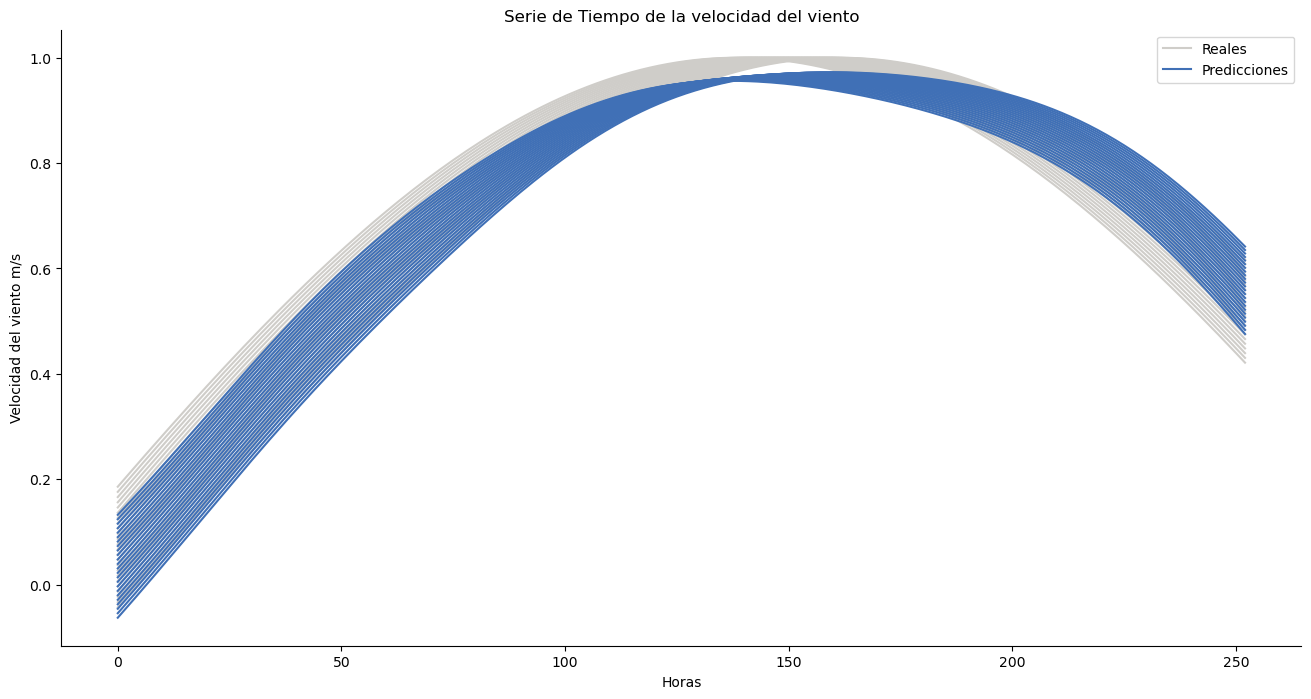

In [22]:
plot_series(test_target, testPred)

In [96]:
%%time
msvr = MSVR(kernel = 'rbf', gamma = 0.1, epsilon=0.001)
msvr.fit(x_[:2], y_[:2])

Wall time: 1.01 ms


In [98]:
%%time
z = {'C': 1, 'epsilon': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}
msvr = MSVR(params = z)
msvr.fit(x_[:2], y_[:2])

1
0.01
0.1
rbf
Wall time: 1.37 ms


In [57]:
# Predict with train set
trainPred = msvr.predict(x_[:2])
# Predict with test set
testPred = msvr.predict(x_[3].reshape(1,-1))

trainMetric = rmse(y_[:2], trainPred)
testMetric = rmse(y_[3].reshape(1,-1), testPred)

print(trainMetric, testMetric)

0.09962219623720196 0.11326671496892884


In [58]:
scl_inv = MinMaxScaler()
# Se obtiene los atributos del scaler utilizado para el fit del modelo
scl_inv.min_, scl_inv.scale_ = minmax_scl.min_[3], minmax_scl.scale_[3]

testPred = scl_inv.inverse_transform(testPred)

IndexError: index 3 is out of bounds for axis 0 with size 1

In [59]:
testPred = minmax_scl.inverse_transform(testPred)

In [61]:
y_[3] = minmax_scl.inverse_transform(y_[3].reshape(1, -1))

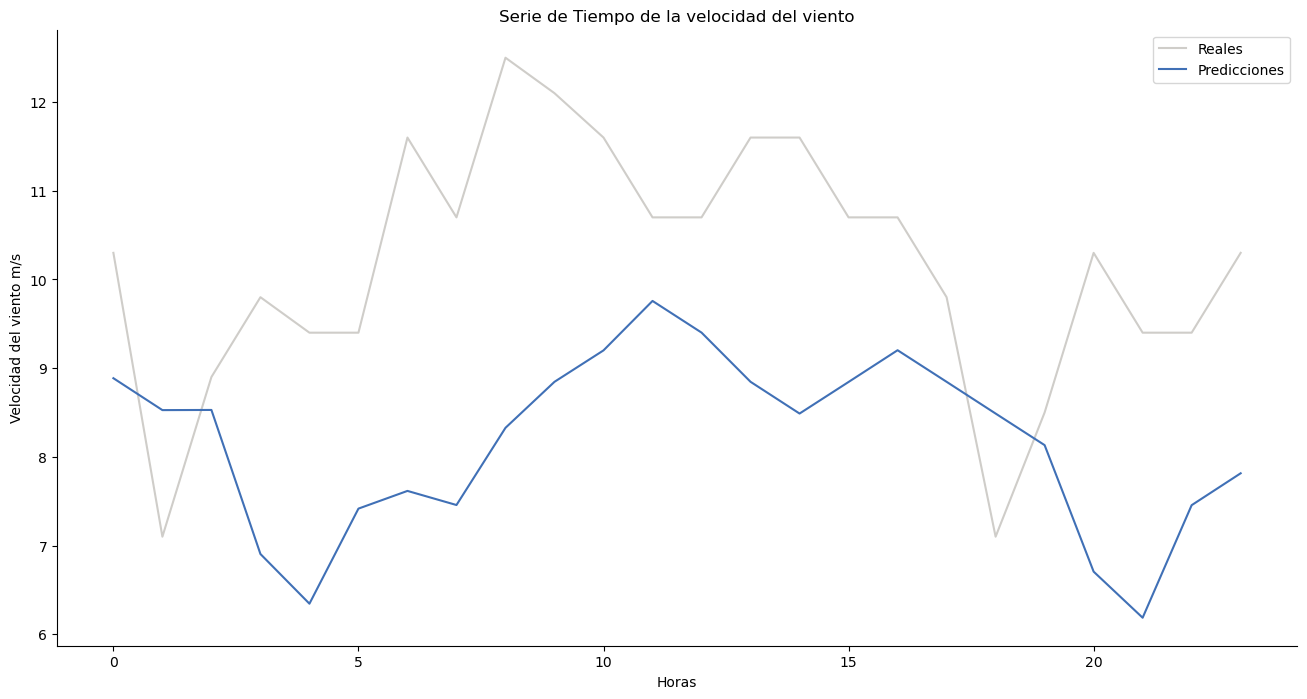

In [62]:
plot_series(y_[3], testPred.flatten())

In [16]:
%%time
msvr = MSVR(kernel = 'rbf', gamma = 0.1, epsilon=0.001)
msvr.fit(x_, y_)

Wall time: 21min 31s


In [17]:
# Predict with train set
trainPred = msvr.predict(x_)
# Predict with test set
#testPred = msvr.predict(y_)

trainMetric = rmse(y_, trainPred)
#testMetric = rmse(y_[3].reshape(1,-1), testPred)

#print(trainMetric, testMetric)

In [18]:
trainMetric

0.11316947904795377

In [ ]:
testPred = msvr.predict(x_)
testMetric = rmse(y_[3].reshape(1,-1), testPred)


In [75]:
trainPred = minmax_scl.inverse_transform(trainPred)
y_ = minmax_scl.inverse_transform(y_)

In [43]:
scl_inv = MinMaxScaler()
# Se obtiene los atributos del scaler utilizado para el fit del modelo
scl_inv.min_, scl_inv.scale_ = minmax_scl.min_[3], minmax_scl.scale_[3]

testPred = scl_inv.inverse_transform(testPred)

In [44]:
y_ = scl_inv.inverse_transform(y_[3].resh)

In [23]:
y_[0]

array([0.55251142, 0.47031963, 0.51141553, 0.47031963, 0.32420091,
       0.40639269, 0.44748858, 0.42922374, 0.42922374, 0.52968037,
       0.48858447, 0.57077626, 0.55251142, 0.52968037, 0.48858447,
       0.48858447, 0.52968037, 0.52968037, 0.48858447, 0.48858447,
       0.44748858, 0.32420091, 0.38812785, 0.47031963])

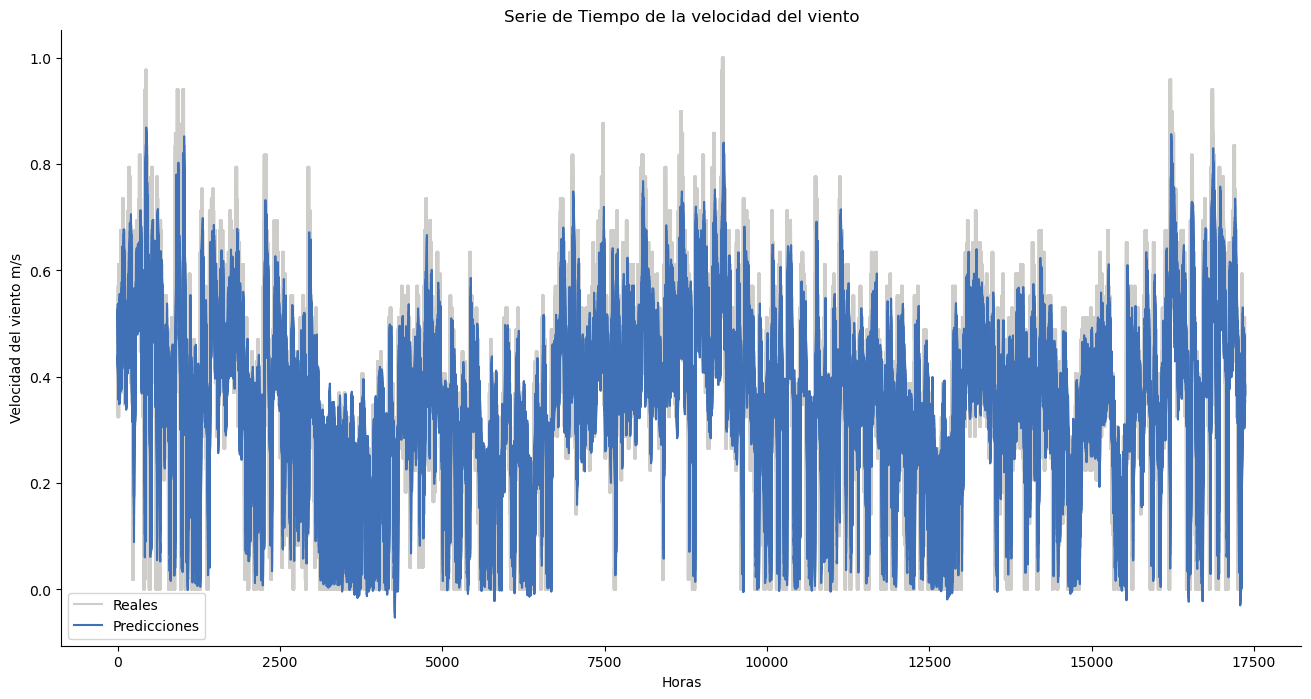

In [29]:
plot_series(y_, trainPred)

In [30]:
df_Prueba = pd.read_csv('./Datasets/Nizanda_22_Prueba.csv')
df_Prueba

,Day,Month,Year,Hour,Barometer,Temp C,High Temp C,Low Temp C,Hum %,Dew Point C,...,Wind Run,High Wind Speed m/s,High Wind Direction,Wind Chill C,Heat Index C,THW Index C,Rain mm,Rain Rate mm/h,ET mm,Date
0,1,1,2022,0,758.9,25.4,25.6,25.3,88.0,23.3,...,1.79,5.4,S,25.4,27.6,27.6,0.0,0.0,0.03,2022-01-01 00:00:00
1,1,1,2022,1,758.7,25.0,25.4,25.0,89.0,23.1,...,1.79,4.9,S,25.0,27.0,27.0,0.0,0.0,0.03,2022-01-01 01:00:00
2,1,1,2022,2,758.2,24.5,25.1,24.5,89.0,22.6,...,1.34,4.5,SSE,24.5,26.2,26.2,0.0,0.0,0.03,2022-01-01 02:00:00
3,1,1,2022,3,757.9,23.8,24.5,23.8,92.0,22.5,...,0.89,4.0,SSW,23.8,25.4,25.4,0.0,0.0,0.03,2022-01-01 03:00:00
4,1,1,2022,4,758.0,23.8,23.9,23.7,91.0,22.2,...,0.89,4.5,SSE,23.8,25.3,25.3,0.0,0.0,0.00,2022-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8752,31,12,2022,19,759.2,28.7,29.6,28.7,61.0,20.5,...,2.24,8.5,W,28.7,30.7,30.7,0.0,0.0,0.08,2022-12-31 19:00:00
8753,31,12,2022,20,759.6,28.3,28.8,28.3,63.0,20.6,...,1.79,7.6,ENE,28.3,30.3,30.3,0.0,0.0,0.08,2022-12-31 20:00:00
8754,31,12,2022,21,760.1,27.7,28.3,27.7,67.0,21.0,...,1.79,6.7,NW,27.7,29.9,29.9,0.0,0.0,0.08,2022-12-31 21:00:00
8755,31,12,2022,22,760.5,27.2,27.8,27.2,73.0,21.9,...,2.24,8.5,NE,27.2,29.7,29.7,0.0,0.0,0.05,2022-12-31 22:00:00


In [31]:
df_test = df_Prueba.copy()
drop_cols = [col for col in df_Prueba.columns if col not in comb[0]]
df_test.drop(drop_cols, axis = 1, inplace = True)

In [32]:
#Prueba
w_test, n_cols = data_preprocessing(df_test, minmax_scl)
x_test, y_test = make_windows(w_test, input_size = comb[1], horizon = comb[2], shift = 0,  n_cols = n_cols)

In [33]:
y_pred = msvr.predict(x_test)

In [37]:
TestMetric = rmse(y_test, y_pred)
TestMetric

0.11600959388258848

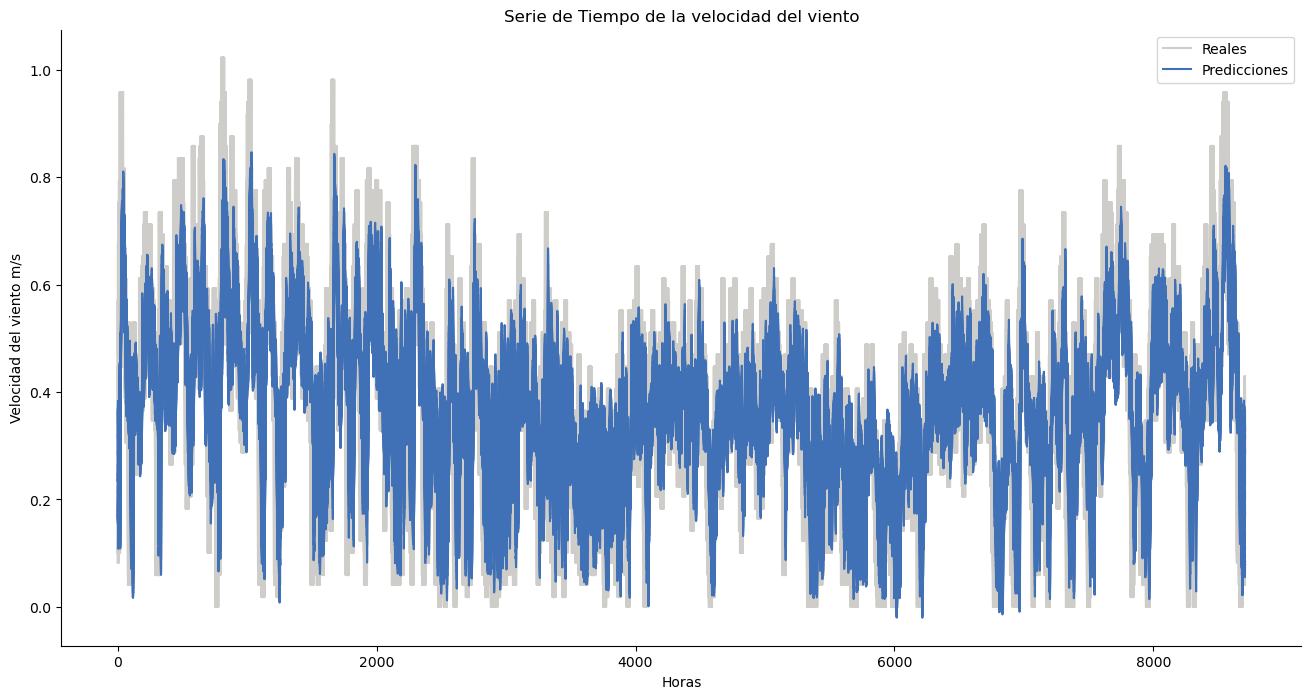

In [38]:
plot_series(y_test, y_pred)

### Usando configuracion de MIMO

In [15]:
comb = list_mimo[0]
comb

(['Month', 'Day', 'Hour', 'High Wind Speed m/s'], 24, 24)

In [16]:
minmax_scl = MinMaxScaler()

df_train = df_Nizanda.copy()
drop_cols = [col for col in df_Nizanda.columns if col not in comb[0]]
df_train.drop(drop_cols, axis = 1, inplace = True)
minmax_scl.fit(df_train)

window = comb[1]
horizon = comb[2]
shift = 0
w, n_cols = data_preprocessing(df_train, minmax_scl)
x_, y_ = make_windows(w, input_size = window, horizon = horizon, shift = shift, n_cols = n_cols)
    
if len(x_.shape) > 2:
        # Convertir a arreglo de 2 dimensiones
        rows, nx, ny = x_.shape
        x_ = x_.reshape((rows, nx*ny))

In [17]:
%%time
msvr = MSVR(kernel = 'rbf', gamma = 0.1, epsilon=0.001)
msvr.fit(x_, y_)

Wall time: 2min 16s


In [18]:
trainPred = msvr.predict(x_)
trainMetric = rmse(y_, trainPred)
trainMetric

0.1012311908117095

In [19]:
trainMetric = rmse(y_, trainPred)
trainMetric

0.1012311908117095

In [20]:
r = mean_squared_error(y_,trainPred, squared = False)
print(r)

0.10989512378001949


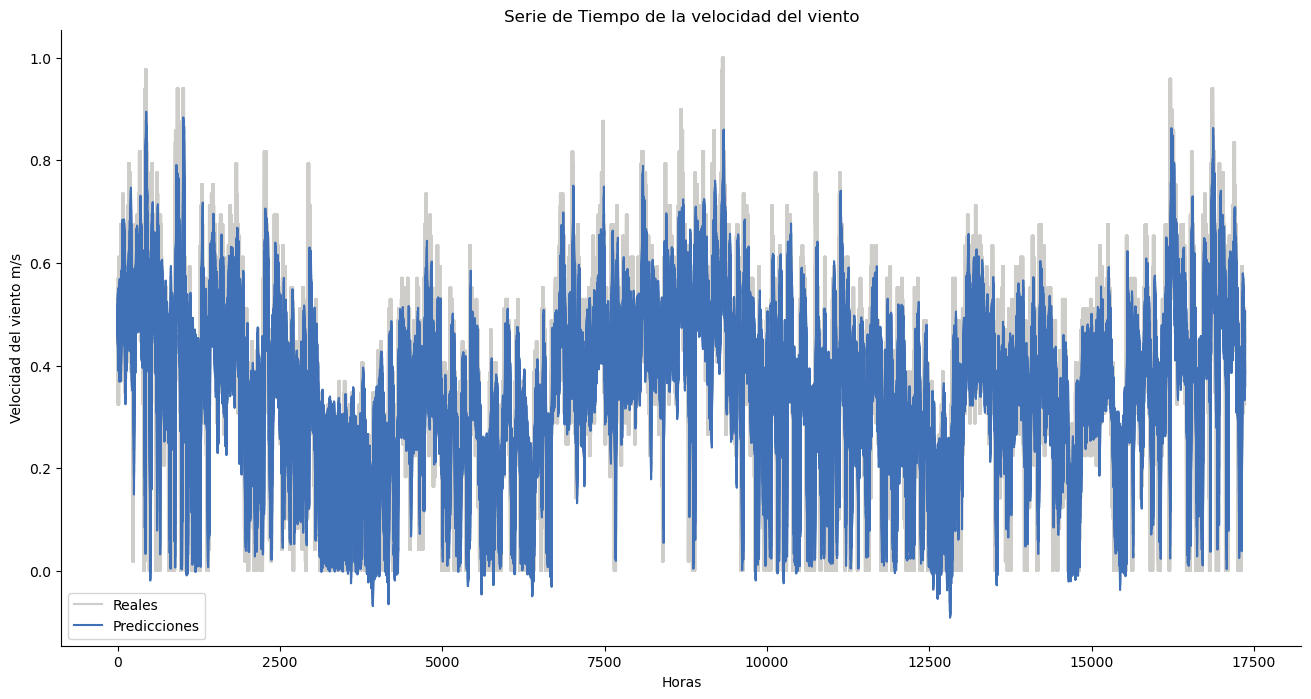

In [21]:
plot_series(y_, trainPred)

In [23]:
scl_inv = MinMaxScaler()
# Se obtiene los atributos del scaler utilizado para el fit del modelo
scl_inv.min_, scl_inv.scale_ = minmax_scl.min_[3], minmax_scl.scale_[3]

testPred_scl = scl_inv.inverse_transform(trainPred)
y_scl = scl_inv.inverse_transform(y_)

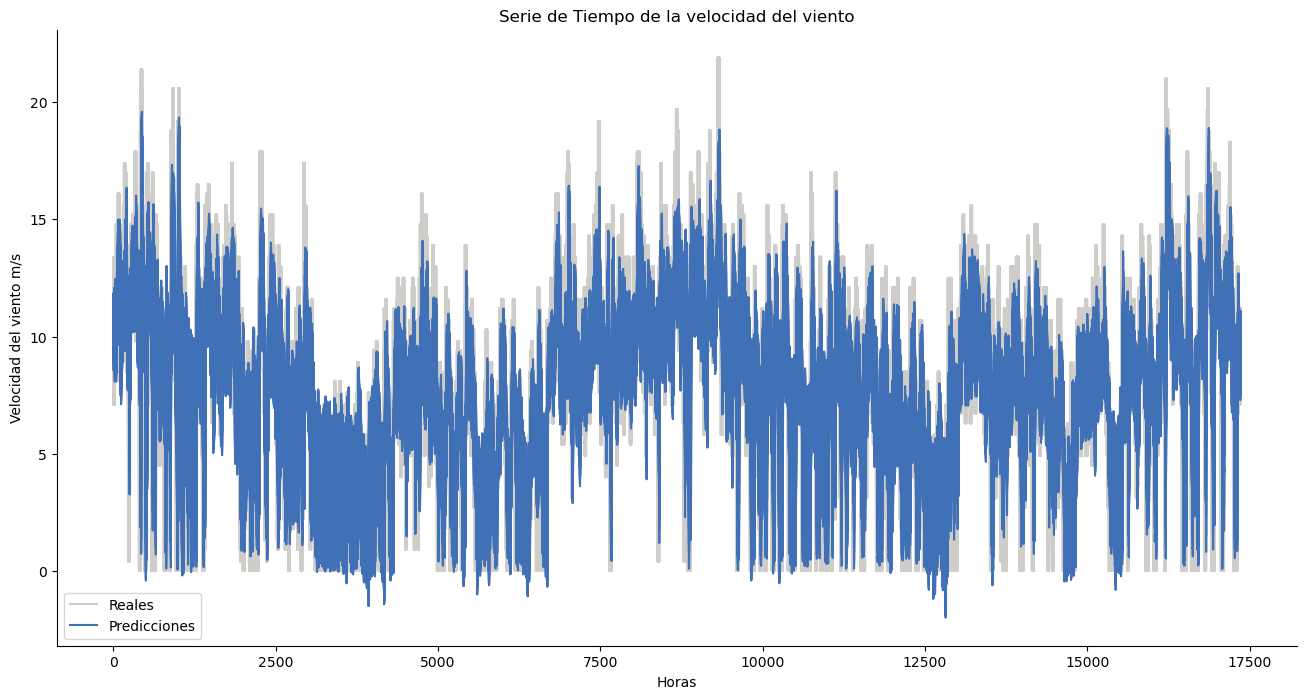

In [24]:
plot_series(y_scl, testPred_scl)

In [25]:
minimo = np.min(testPred_scl) #testPred_scl.min
print(minimo)
maximo = np.max(testPred_scl)
print(maximo)

-2.004153104572238
19.595730746054087


In [26]:
minimo = np.min(y_scl) #testPred_scl.min
print(minimo)
maximo = np.max(y_scl)
print(maximo)

0.0
21.9


In [27]:
s = unpadding(y_)
print(s[:24])
print('-Sin descomprimir-')
print(y_[0])

[0.55251142 0.47031963 0.51141553 0.47031963 0.32420091 0.40639269
 0.44748858 0.42922374 0.42922374 0.52968037 0.48858447 0.57077626
 0.55251142 0.52968037 0.48858447 0.48858447 0.52968037 0.52968037
 0.48858447 0.48858447 0.44748858 0.32420091 0.38812785 0.47031963]
-Sin descomprimir-
[0.55251142 0.47031963 0.51141553 0.47031963 0.32420091 0.40639269
 0.44748858 0.42922374 0.42922374 0.52968037 0.48858447 0.57077626
 0.55251142 0.52968037 0.48858447 0.48858447 0.52968037 0.52968037
 0.48858447 0.48858447 0.44748858 0.32420091 0.38812785 0.47031963]


In [28]:
print('-Sin descomprimir-')
r2_s = r2_score(y_, trainPred)
print(r2_s)
print('-Descomprimdor-')
r2 = r2(y_, trainPred)
print(r2)

-Sin descomprimir-
0.6609785505427316
-Descomprimdor-
0.7206798606974116


In [29]:
print('-Sin descomprimir-')
mae_s = mean_absolute_error(y_, trainPred)
print(mae_s)
print('-Descomprimdor-')
mae_score = mae(y_, trainPred)
print(mae_score)

-Sin descomprimir-
0.08345974917333365
-Descomprimdor-
0.07732133739020453


In [ ]:
### Implementacion de Gridsearchcv para MSVR
tscv = TimeSeriesSplit(n_splits = 4)
params = {'C': [1, 10, 100, 1000], 'epsilon': [0.001, 0.01, 0.1, 1], 'gamma': [0.001, 0.01, 0.1, 1],'kernel': ['rbf']}
keys = ['epsilon', 'C', 'gamma']
bestparams = {'C': [1], 'epsilon': [0.1], 'gamma': [0.1],'kernel': ['rbf']}
    # Probando el SVR y GridSearchCV
    for j in range(3):
        print('--Etapa ' + str(j + 1) + '--')
        print('GS: '+ str(keys[j]))
        bestparams.update({keys[j]: params[keys[j]]})
        print(bestparams)
        reg = GridSearchCV(estimator = model, param_grid = bestparams, cv = tscv, scoring = 'r2', n_jobs = -1, verbose = True)
        reg.fit(x_, y_)
        bestparams.update({keys[j]: [reg.best_params_[keys[j]]]})